# Л.р. №5: Непараметрическая регрессия

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import train_test_split, cross_val_score
from numpy.linalg import norm

/home/pokrasko/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Часть 1. Обработка и визуализация данных

In [4]:
data = pd.read_csv("non-parametric.csv", sep=";", index_col="id")

In [5]:
X = data["x"].values
y = data["y"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

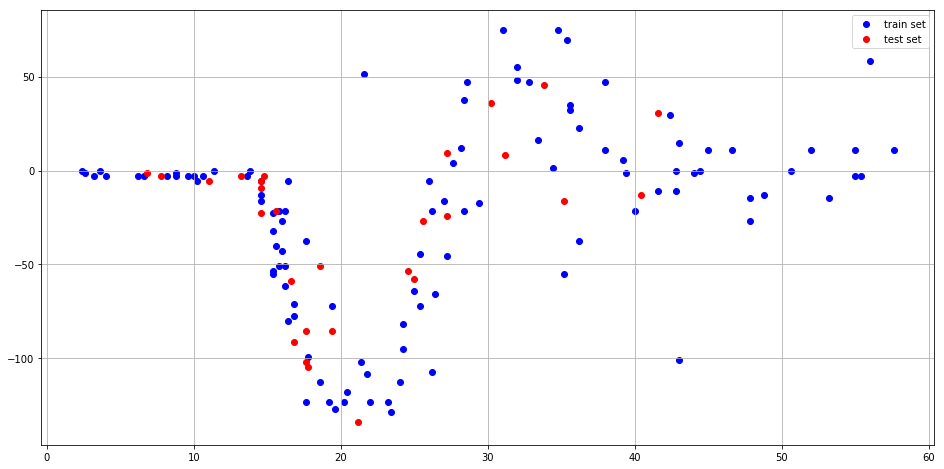

In [15]:
plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, c="b", label="train set")
plt.scatter(X_test, y_test, c="r", label="test set")
plt.legend(loc=1)
plt.grid()
plt.show()

## Часть 2. Формула ядерного сглаживания Надарая-Ватсона

In [8]:
euclidean_metric = lambda x, y: np.sqrt(np.dot(x - y, x - y))

In [9]:
rectangular_kernel = lambda x: 1             if abs(x) <= 1 else 0
triangular_kernel  = lambda x: 1 - abs(x)    if abs(x) <= 1 else 0
quartic_kernel     = lambda x: (1 - x**2)**2 if abs(x) <= 1 else 0
gaussian_kernel    = lambda x: np.exp(-2*(x**2))

In [10]:
class NadarayaWatsonRegression(BaseEstimator):
    def __init__(self, kernel_func, k, metric=euclidean_metric):
        self.kernel_func = kernel_func
        self.k = k
        self.metric = metric

    def get_params(self, deep=False):
        return {"kernel_func": self.kernel_func,
                "k": self.k,
                "metric": self.metric}

    def set_params(self, **params):
        self.kernel_func = params["kernel_func"]
        self.k = params["k"]
        self.metric = params["metric"]

    def fit(self, X, y):
        self.X = X
        self.y = y

        # precalculate h_i
        self.hs = []
        for i in range(len(self.X)):
            xi = self.X[i]
            dists = list(map(lambda y: self.metric(xi, y), self.X))
            hi = np.partition(dists, self.k, axis=0)[self.k]
            self.hs.append(hi)

    def predict(self, X):
        ys = []
        for x in X:
            n = 0 
            d = 0
            for xi, yi, hi in zip(self.X, self.y, self.hs):
                z = self.kernel_func(self.metric(x, xi) / hi)
                n += yi * z
                d += z
            ys.append(n / d)
        return np.array(ys)

In [13]:
def plot_nadaraya_watson(kernel, ks, title):
    x_curve = np.arange(0, 60, 0.1)
    ys_curve = []
    mses = {"train": [], "test": []}
    for k in ks:
        nw = NadarayaWatsonRegression(kernel, k)
        nw.fit(X_train, y_train)
        y_curve = nw.predict(x_curve)
        ys_curve.append(y_curve)
        for xs, ys, err_type in zip([X_train, X_test], [y_train, y_test], ["train", "test"]):
            y_pred = nw.predict(xs)
            err = euclidean_metric(ys, y_pred) / len(ys)
            print("k=%d: mse_%s=%.2f" % (k, err_type, err))

    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.scatter(X_train, y_train, c="b", label="train set")
    plt.scatter(X_test, y_test, c="r", label="test set")
    for k, y_curve in zip(ks, ys_curve):
        plt.plot(x_curve, y_curve, label="k = %d" % k)
    plt.legend(loc=1)
    plt.ylim(-150, 150)
    plt.grid()
    plt.show()

k=5: mse_train=2.65
k=5: mse_test=4.26
k=10: mse_train=2.80
k=10: mse_test=4.08
k=15: mse_train=2.82
k=15: mse_test=3.57


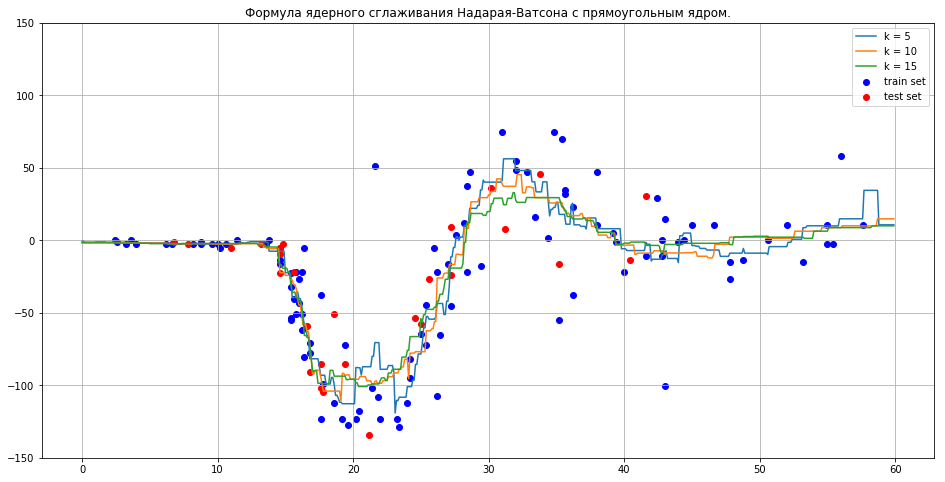

In [14]:
plot_nadaraya_watson(rectangular_kernel, [5, 10, 15], "Формула ядерного сглаживания Надарая-Ватсона с прямоугольным ядром.")

- Кусочно-постоянная аппроксимация

k=5: mse_train=2.37
k=5: mse_test=4.84
k=10: mse_train=2.58
k=10: mse_test=4.38
k=15: mse_train=2.67
k=15: mse_test=3.98


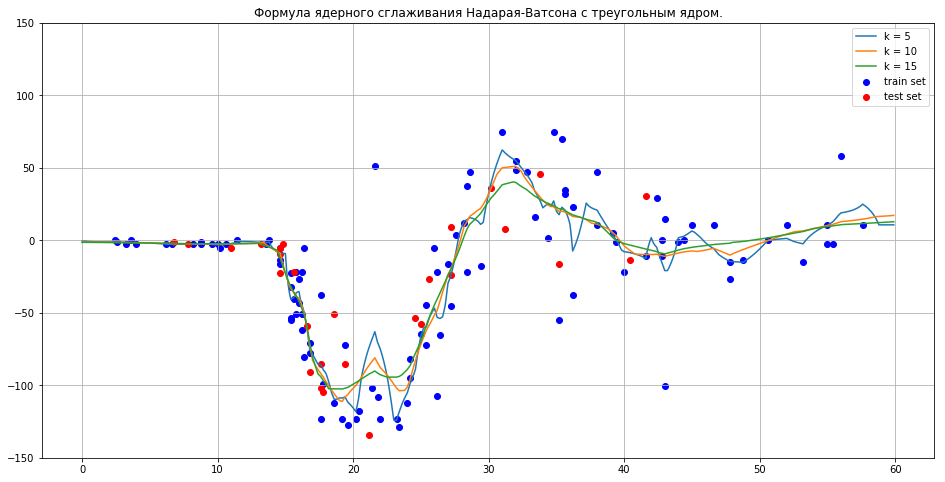

In [16]:
plot_nadaraya_watson(triangular_kernel, [5, 10, 15], "Формула ядерного сглаживания Надарая-Ватсона с треугольным ядром.")

- Кусочно-линейная аппроксимация

k=5: mse_train=2.47
k=5: mse_test=4.69
k=10: mse_train=2.64
k=10: mse_test=4.24
k=15: mse_train=2.72
k=15: mse_test=3.87


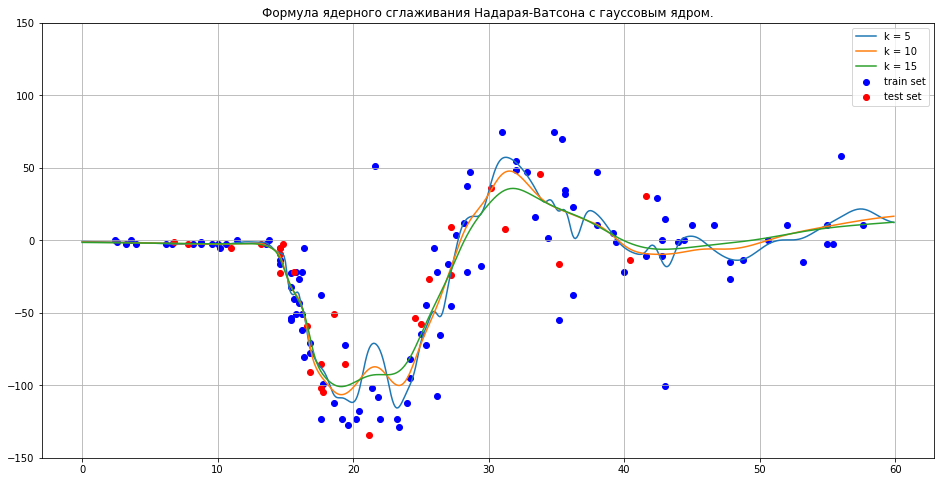

In [17]:
plot_nadaraya_watson(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания Надарая-Ватсона с гауссовым ядром.")

- Гладкая аппроксимация

**Выводы**:
* Качество классификации сильно зависит от ширины окна $h_k(x)$
* Выбор ядра, напротив, слабо влияет на качество классификации, но влияет на гладкость $a(x)$

## Часть 3. Робастная непараметрическая регрессия. Алгоритм LOWESS

In [18]:
class LOWESSRegression(BaseEstimator):
    def __init__(self, kernel_func, k, metric=euclidean_metric):
        self.kernel_func = kernel_func
        self.k = k
        self.metric = metric

    def get_params(self, deep=False):
        return {"kernel_func": self.kernel_func,
                "k": self.k,
                "metric": self.metric}

    def set_params(self, **params):
        self.kernel_func = params["kernel_func"]
        self.k = params["k"]
        self.metric = params["metric"]

    def _loo(self, i, gammas):
        n = 0
        d = 0
        xi = self.X[i]
        hi = self.hs[i]

        for j, (xj, yj, γj) in enumerate(zip(self.X, self.y, gammas)):
            if i == j: continue
            k = self.kernel_func(self.metric(xi, xj) / hi)
            n += yj * γj * k
            d += γj * k
        return n / d

    def fit(self, X, y):
        self.X = X
        self.y = y
        N = len(self.X)
        gammas = [1.] * N

        # precalculate h_i
        self.hs = []
        for i in range(N):
            xi = self.X[i]
            dists = list(map(lambda y: self.metric(xi, y), self.X))
            hi = np.partition(dists, self.k, axis=0)[self.k]
            self.hs.append(hi)

        for t in range(50):
            answers = []
            errs = []
            for i in range(N):
                answers.append(self._loo(i, gammas))
            for i in range(N):
                errs.append(abs(answers[i] - self.y[i]))
            err_median = np.median(errs)
            mean_change = 0
            for i in range(N):
                # soft filtration kernel
                newval = quartic_kernel(errs[i] / (6 * err_median))
                mean_change += abs(newval - gammas[i])
                gammas[i] = newval
            if mean_change / N <= 1e-6:
                break
            
        self.gammas = np.array(gammas)

    def predict(self, X):
        ys = []
        for x in X:
            n = 0
            d = 0
            for xi, yi, γi, hi in zip(self.X, self.y, self.gammas, self.hs):
                k = self.kernel_func(self.metric(x, xi) / hi)
                n += yi * γi * k
                d += γi * k
            ys.append(n / d)
        return np.array(ys)

In [19]:
def plot_lowess(kernel, ks, title):
    x_curve = np.arange(0, 60, 0.1)
    ys_curve = []
    mses = {"train": [], "test": []}
    for k in ks:
        nw = LOWESSRegression(kernel, k)
        nw.fit(X_train, y_train)
        y_curve = nw.predict(x_curve)
        ys_curve.append(y_curve)
        for xs, ys, err_type in zip([X_train, X_test], [y_train, y_test], ["train", "test"]):
            y_pred = nw.predict(xs)
            err = euclidean_metric(ys, y_pred) / len(ys)
            print("k=%d: mse_%s=%.2f" % (k, err_type, err))

    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.scatter(X_train, y_train, c="b", label="train set")
    plt.scatter(X_test, y_test, c="r", label="test set")
    for k, y_curve in zip(ks, ys_curve):
        plt.plot(x_curve, y_curve, label="k = %d" % k)
    plt.legend(loc=1)
    plt.ylim(-150, 150)
    plt.grid()
    plt.show()

k=5: mse_train=2.83
k=5: mse_test=4.35
k=10: mse_train=2.84
k=10: mse_test=4.07
k=15: mse_train=2.82
k=15: mse_test=3.88


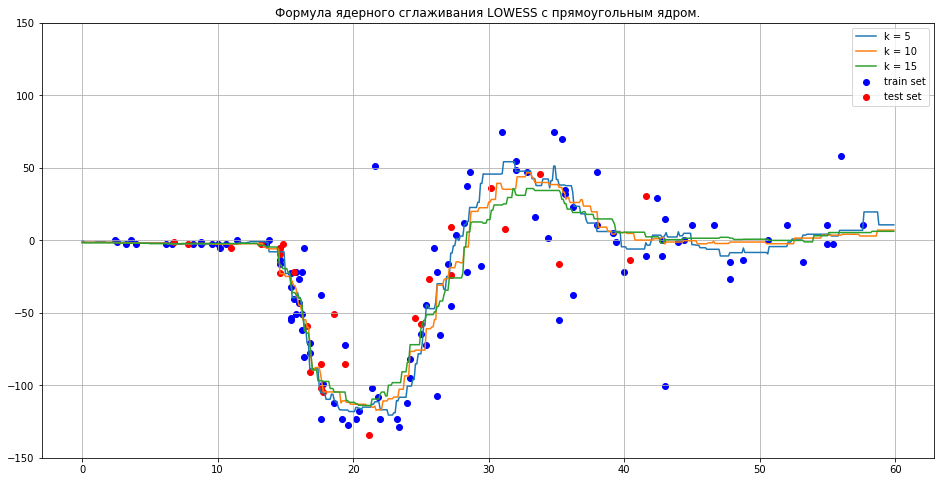

In [20]:
plot_lowess(rectangular_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с прямоугольным ядром.")

k=5: mse_train=2.76
k=5: mse_test=4.94
k=10: mse_train=2.79
k=10: mse_test=4.27
k=15: mse_train=2.81
k=15: mse_test=4.06


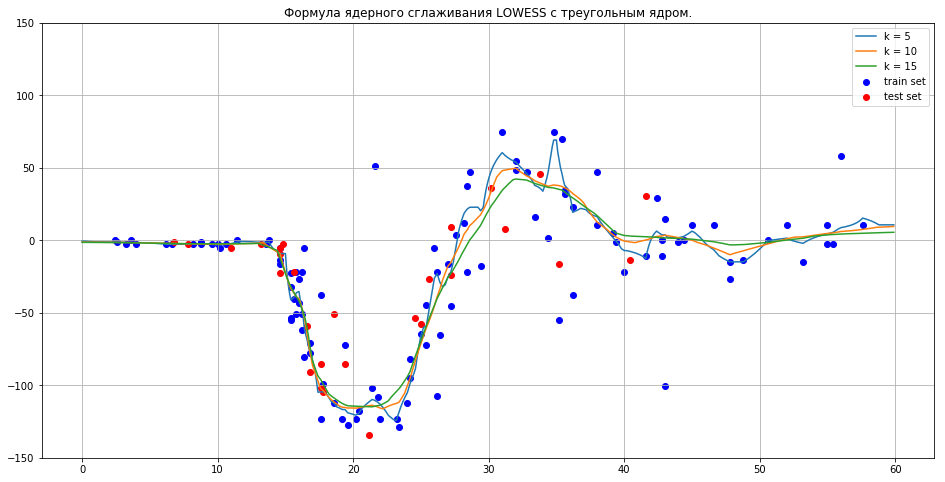

In [21]:
plot_lowess(triangular_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с треугольным ядром.")

k=5: mse_train=2.76
k=5: mse_test=4.65
k=10: mse_train=2.78
k=10: mse_test=4.14
k=15: mse_train=2.80
k=15: mse_test=3.94


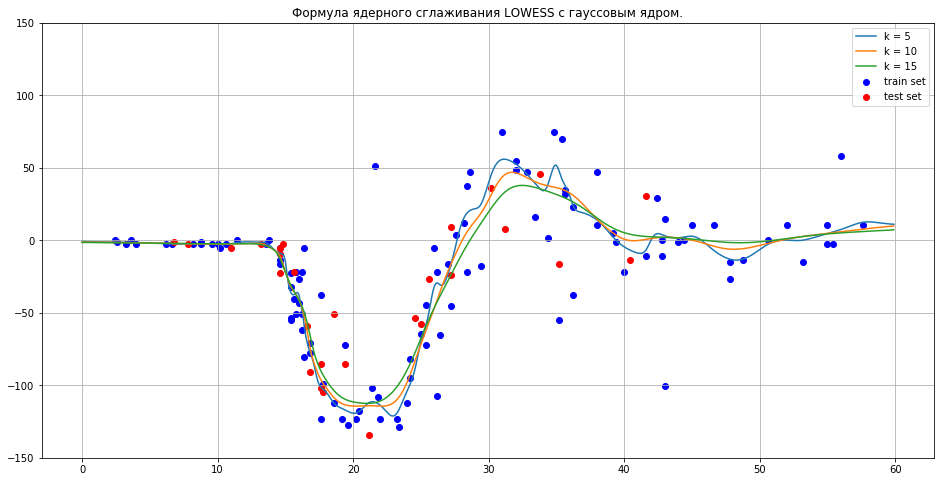

In [22]:
plot_lowess(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с гауссовым ядром.")

## Часть 4. Проверка робастности

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
for x_dropout in np.arange(0, 60, 5):
    eps = 0.1
    X_train = np.append(X_train, [x_dropout - eps, x_dropout + eps])
    y_train = np.append(y_train, [-1000, 1000])

k=5: mse_train=36.31
k=5: mse_test=12.62
k=10: mse_train=37.09
k=10: mse_test=7.11
k=15: mse_train=37.17
k=15: mse_test=4.44


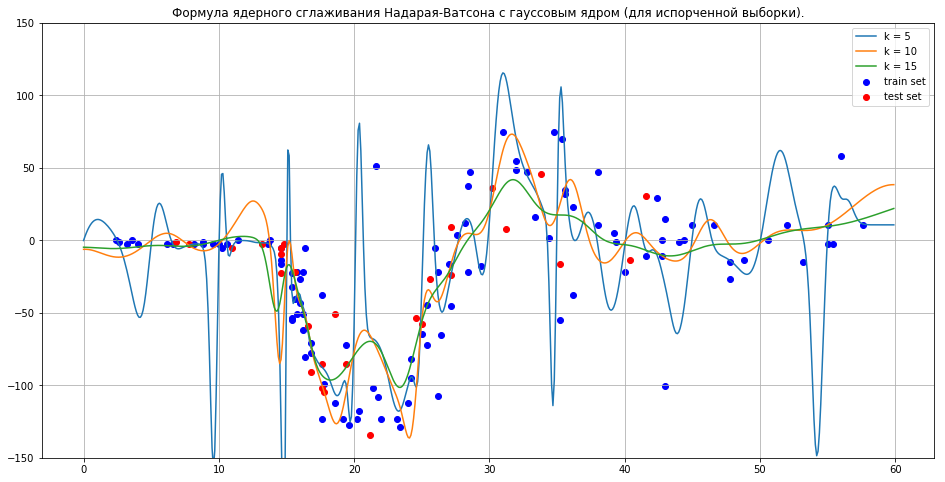

In [25]:
plot_nadaraya_watson(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания Надарая-Ватсона с гауссовым ядром (для испорченной выборки).")

k=5: mse_train=37.19
k=5: mse_test=4.63
k=10: mse_train=37.21
k=10: mse_test=4.20
k=15: mse_train=37.21
k=15: mse_test=3.92


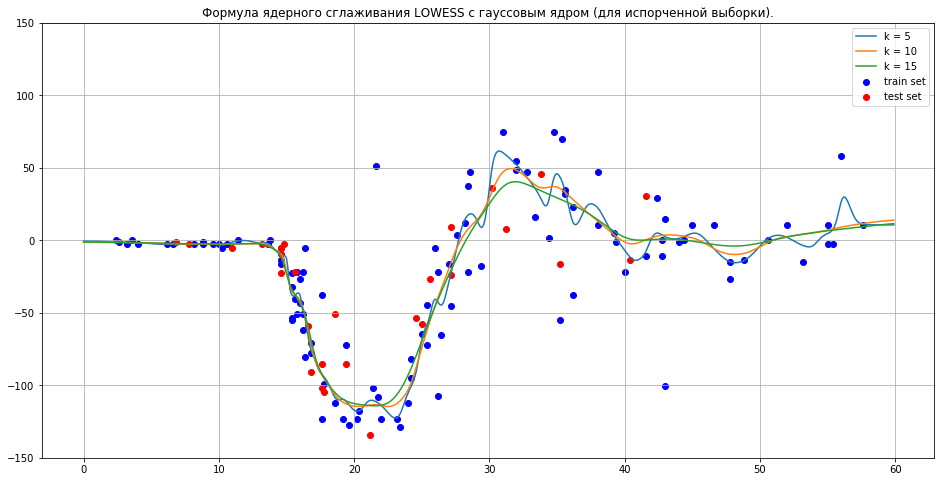

In [26]:
plot_lowess(gaussian_kernel, [5, 10, 15], "Формула ядерного сглаживания LOWESS с гауссовым ядром (для испорченной выборки).")

---

**Источники:**

* *К. В. Воронцов, «Математические методы обучения по прецедентам», глава «Методы восстановления регрессии» (http://machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)*